In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
# from deside.utility import cancer_types, check_dir, read_marker_gene, calculate_rmse, set_fig_style
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set
from deside.utility.compare import read_and_merge_result, cal_gene_signature_score
from deside.utility import (ExpObj, set_fig_style, sorted_cell_types, read_marker_gene,
                            get_corr, check_dir, cancer_types, get_ccc, 
                            read_cancer_purity, calculate_rmse)
# sns.set(font_scale=2)
# sns.set_style("white")
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-01-09 20:57:16.698641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
result_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/'
dataset_dir = r'../datasets/'
fig_dir = './fig3/'
model_evaluation_dir = '../tables_model_evaluation/'

## Evaluate the performance based on TCGA and CPE across different algorithms 

### Merge predicted cell proportions across different cancer types for each algorithm

In [3]:
merged_dir = os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'merged_result')
cancer_purity_file_path = os.path.join(dataset_dir, 'cancer_purity', 'cancer_purity.csv')
tcga_sample_id2cancer_type_file_path = os.path.join(dataset_dir, 'TCGA', 'tpm', 'tcga_sample_id2cancer_type.csv')
if os.path.exists(merged_dir):
    shutil.rmtree(merged_dir)
check_dir(merged_dir)

In [4]:
algos = ['DeSide', 'DeSide_softmax', 'CIBERSORT_hnscc', 'EPIC_self', 'Scaden_ascites', 'Kassandra_self', 'CIBERSORT_luad', 'Scaden_simu_bulk']
algo2merged_file_path = {i: os.path.join(merged_dir, f'{i}_pred_cell_prop.csv') for i in algos}
algo2merged_file_path

{'DeSide': '../tables_model_evaluation/predicted_cell_fractions/merged_result/DeSide_pred_cell_prop.csv',
 'DeSide_softmax': '../tables_model_evaluation/predicted_cell_fractions/merged_result/DeSide_softmax_pred_cell_prop.csv',
 'CIBERSORT_hnscc': '../tables_model_evaluation/predicted_cell_fractions/merged_result/CIBERSORT_hnscc_pred_cell_prop.csv',
 'EPIC_self': '../tables_model_evaluation/predicted_cell_fractions/merged_result/EPIC_self_pred_cell_prop.csv',
 'Scaden_ascites': '../tables_model_evaluation/predicted_cell_fractions/merged_result/Scaden_ascites_pred_cell_prop.csv',
 'Kassandra_self': '../tables_model_evaluation/predicted_cell_fractions/merged_result/Kassandra_self_pred_cell_prop.csv',
 'CIBERSORT_luad': '../tables_model_evaluation/predicted_cell_fractions/merged_result/CIBERSORT_luad_pred_cell_prop.csv',
 'Scaden_simu_bulk': '../tables_model_evaluation/predicted_cell_fractions/merged_result/Scaden_simu_bulk_pred_cell_prop.csv'}

In [5]:
pred_dir = './predicted_cell_prop'
algo2raw_result_dir = {
    'CIBERSORT_hnscc' : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'CIBERSORT_result', 'HNSCC_ref'),
    'CIBERSORT_luad'  : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'CIBERSORT_result', 'LUAD_ref'),
    'DeSide'          : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'DeSide_result', 'sigmoid_20231110_003'),
    'DeSide_softmax'  : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'DeSide_result', 'softmax_20231110_005'),
    'EPIC_self'       : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'EPIC_1125', 'EPIC_self_sig_and_ct', 'data'),
    'Scaden_ascites'  : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'Scaden_result', 'human_ascites_local'),
    'Scaden_simu_bulk': os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'Scaden_result', 'simu_bulk_merged_2ds_local'),
    'Kassandra_self'  : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'Kassandra_result')
}
algo2raw_result_dir

{'CIBERSORT_hnscc': '../tables_model_evaluation/predicted_cell_fractions/CIBERSORT_result/HNSCC_ref',
 'CIBERSORT_luad': '../tables_model_evaluation/predicted_cell_fractions/CIBERSORT_result/LUAD_ref',
 'DeSide': '../tables_model_evaluation/predicted_cell_fractions/DeSide_result/sigmoid_20231110_003',
 'DeSide_softmax': '../tables_model_evaluation/predicted_cell_fractions/DeSide_result/softmax_20231110_005',
 'EPIC_self': '../tables_model_evaluation/predicted_cell_fractions/EPIC_1125/EPIC_self_sig_and_ct/data',
 'Scaden_ascites': '../tables_model_evaluation/predicted_cell_fractions/Scaden_result/human_ascites_local',
 'Scaden_simu_bulk': '../tables_model_evaluation/predicted_cell_fractions/Scaden_result/simu_bulk_merged_2ds_local',
 'Kassandra_self': '../tables_model_evaluation/predicted_cell_fractions/Kassandra_result'}

In [6]:
cell_type2subtypes = {'B Cells': ['Non-plasma B cells', 'Plasma B cells'],
                      'CD4 T': ['CD4 T'], 'CD8 T': ['CD8 T (GZMK high)', 'CD8 T effector'],
                      'DC': ['DC'], 'Endothelial Cells': ['Endothelial Cells'],
                      'Cancer Cells': ['Cancer Cells'],
                      'Fibroblasts': ['CAFs', 'Myofibroblasts'], 'Macrophages': ['Macrophages'],
                      'Mast Cells': ['Mast Cells'], 'NK': ['NK'], 'Neutrophils': ['Neutrophils'],
                      'Double-neg-like T': ['Double-neg-like T'], 'Monocytes': ['Monocytes']}
all_cell_types = sorted([i for v in cell_type2subtypes.values() for i in v])
all_cell_types

['CAFs',
 'CD4 T',
 'CD8 T (GZMK high)',
 'CD8 T effector',
 'Cancer Cells',
 'DC',
 'Double-neg-like T',
 'Endothelial Cells',
 'Macrophages',
 'Mast Cells',
 'Monocytes',
 'Myofibroblasts',
 'NK',
 'Neutrophils',
 'Non-plasma B cells',
 'Plasma B cells']

In [7]:
sorted_cell_type_list2 = ['B Cells', 'CD4 T', 'CD8 T', 'Cancer Cells', 'DC', 'Endothelial Cells', 'Fibroblasts', 'Macrophages', 'Mast Cells', 'NK', 'Neutrophils']

In [8]:
# mapping cell type names
ct_without_neutrophils = [i for i in sorted_cell_type_list2 if i != 'Neutrophils']
algo2cell_type_name_mapping = {
        'CIBERSORT_hnscc': {'B cell': 'B Cells', 'T cells CD4': 'CD4 T', 'T cells CD8': 'CD8 T', 'Dendritic': 'DC',
                            'Malignant': 'Cancer Cells', 'Endothelial': 'Endothelial Cells',
                            'Fibroblast': 'Fibroblasts', 'Macrophage': 'Macrophages', 'Mast': 'Mast Cells',
                            },
        'CIBERSORT_luad': dict(zip(ct_without_neutrophils, ct_without_neutrophils)),
        'DeSide': dict(zip(all_cell_types, all_cell_types)),
        'DeSide_softmax': dict(zip(all_cell_types, all_cell_types)),
        'EPIC_self': {'B.cells': 'B Cells', 'CD4.T': 'CD4 T', 'CD8.T': 'CD8 T',
                      'otherCells': 'Cancer Cells', 'Endothelial.Cells': 'Endothelial Cells',
                      'Fibroblasts': 'Fibroblasts',  'NK': 'NK', 'Macrophages': 'Macrophages',
                      },
        'Scaden_ascites': {'CD4Tcells': 'CD4 T', 'CD8Tcells': 'CD8 T', 'Carcinoma': 'Cancer Cells',
                           'DC': 'DC', 'Fibroblast': 'Fibroblasts', 'NK': 'NK',
                          },
        'Scaden_simu_bulk': dict(zip(sorted_cell_type_list2, sorted_cell_type_list2)),
        'Kassandra_self': {'B_cells': 'B Cells', 'CD4_T_cells': 'CD4 T', 'CD8_T_cells': 'CD8 T',
                           'Endothelium': 'Endothelial Cells', 'Fibroblasts': 'Fibroblasts', 'Macrophages': 'Macrophages',
                           'NK_cells': 'NK', 'Neutrophils': 'Neutrophils', 'Other': 'Cancer Cells'},
}

In [9]:
for algo, m_fp in algo2merged_file_path.items():
    print(f'Merge the results of {algo}...')
    read_and_merge_result(raw_result_dir=algo2raw_result_dir[algo], algo=algo,
                          result_file_path=algo2merged_file_path[algo],
                          cell_type_name_mapping=algo2cell_type_name_mapping[algo],
                          tcga_sample2cancer_type_file_path=tcga_sample_id2cancer_type_file_path)

Merge the results of DeSide...
Merge the results of DeSide_softmax...
Merge the results of CIBERSORT_hnscc...
Merge the results of EPIC_self...
Merge the results of Scaden_ascites...
Merge the results of Kassandra_self...
Merge the results of CIBERSORT_luad...
Merge the results of Scaden_simu_bulk...


In [10]:
tcga_sample_id2cancer_type = pd.read_csv(tcga_sample_id2cancer_type_file_path, index_col=0)
print(tcga_sample_id2cancer_type.shape)
tcga_sample_id2cancer_type.head(2)

(7699, 1)


,cancer_type
TCGA-OR-A5LO-01A,ACC
TCGA-P6-A5OG-01A,ACC


In [11]:
cpe = read_cancer_purity(cancer_purity_file_path=cancer_purity_file_path, sample_names=tcga_sample_id2cancer_type.index.to_list())
print(cpe.shape)
cpe.head(2)

(7452, 7)


,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,Unnamed: 7
Sample ID,,,,,,,
TCGA-DD-AAE2-01A,LIHC,0.8116,NaN,NaN,0.8,0.7060,NaN
TCGA-HT-A4DS-01A,LGG,0.8673,NaN,0.8567,0.9,0.8663,NaN


In [12]:
tcga_cpe_intersection = tcga_sample_id2cancer_type.merge(cpe.loc[:, ['CPE']], left_index=True, right_index=True)
tcga_cpe_intersection.index = tcga_cpe_intersection.index.map(lambda x: x.replace('.', '-'))
print(tcga_cpe_intersection.shape)
tcga_cpe_intersection.head(2)

(7452, 2)


,cancer_type,CPE
TCGA-OR-A5LO-01A,ACC,0.9954
TCGA-P6-A5OG-01A,ACC,0.4616


In [13]:
algo_new_names = {
    'DeSide': 'DeSide \n (Simu bulk)', 'DeSide_softmax': 'DeSide \n (softmax)', 'CIBERSORT_hnscc': 'CIBERSORT \n (HNSCC)', 'CIBERSORT_luad': 'CIBERSORT \n (LUAD)', 
    'EPIC_self': 'EPIC \n (Default)', 'Scaden_ascites': 'Scaden \n (Ascites)', 
    'Scaden_simu_bulk': 'Scaden \n (Simu bulk)', 'Kassandra_self': 'Kassandra \n (Default)'
}

In [14]:
def compare_y_y_pred(y_true: pd.Series, y_pred: pd.Series, cancer_type='', algo=''):
    """
    Calculate correlation, RMSM, and CCC between y and y_pred

    :param y_true: CPE

    :param y_pred: this file contains the predicted value of y

    :param cancer_type: cancer type

    :param algo: algorithm name

    :return: correlatin, RMSE, CCC
    """
    corr = 0
    rmse = 0
    ccc = 0
    corr = get_corr(y_pred, y_true)
    rmse = calculate_rmse(y_true=pd.DataFrame(y_true), y_pred=pd.DataFrame(y_pred))
    ccc = get_ccc(y_pred.values, y_true.values)

    return corr, rmse, ccc

In [15]:
metrics_value = {}
cancer_types2 = [i for i in cancer_types if i != 'PAAD']

In [16]:
# y_true = ReadH5AD(y_true_file_path).get_cell_fraction()
for ct in cancer_types2:
    current_cancer_type = ct
    print(f'Dealing with {current_cancer_type}...')
    current_cpe = tcga_cpe_intersection.loc[tcga_cpe_intersection['cancer_type'] == current_cancer_type, 'CPE']
    for algo in algos:
        current_algo = algo
        y_pred_file_path = algo2merged_file_path[current_algo]
        # print(y_pred.shape, current_cpe.shape, y_pred_file_path)
        y_pred = pd.read_csv(y_pred_file_path, index_col='sample_id').loc[current_cpe.index, 'Cancer Cells']
        corr, rmse, ccc = compare_y_y_pred(y_pred=y_pred, y_true=current_cpe, cancer_type=current_cancer_type, algo=algo_new_names[current_algo])
        metrics_value[(current_algo, current_cancer_type)] = {'corr': corr, 'rmse': rmse, 'ccc': ccc}

Dealing with ACC...
Dealing with BLCA...
Dealing with BRCA...
Dealing with GBM...
Dealing with HNSC...


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Dealing with LGG...
Dealing with LIHC...
Dealing with LUAD...
Dealing with PRAD...
Dealing with CESC...
Dealing with COAD...
Dealing with KICH...
Dealing with KIRC...


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Dealing with KIRP...
Dealing with LUSC...
Dealing with READ...
Dealing with THCA...
Dealing with UCEC...


In [17]:
metrics_value_df = pd.DataFrame.from_dict(metrics_value, orient='index')
metrics_value_df.index.names = ['algorithm', 'cancer_type']
print(metrics_value_df.shape)
metrics_value_df.head(2)

(144, 3)


,,corr,rmse,ccc
algorithm,cancer_type,,,
DeSide,ACC,0.784109,0.134205,0.555562
DeSide_softmax,ACC,0.818602,0.146500,0.547905


In [18]:
metrics_value_df.to_csv(os.path.join(fig_dir, 'pred_cancer_cell_prop_vs_cpe.csv'), float_format='%.3f')

#### Bar plot to compare CCC value across 5 different algorithms 
- Predicted cell proportions of cancer cells vs CPE (Fig. S3-S4)

In [19]:
ccc_values = pd.read_csv(os.path.join(fig_dir, 'pred_cancer_cell_prop_vs_cpe.csv'))
print(ccc_values.shape)
ccc_values.head(2)

(144, 5)


,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548


In [20]:
ccc_values_5_algo = ccc_values.loc[~ccc_values['algorithm'].isin(['CIBERSORT_luad', 'Scaden_simu_bulk', 'DeSide_softmax']), :].copy()
print(ccc_values_5_algo.shape)
ccc_values_5_algo.head(2)

(90, 5)


,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
2,CIBERSORT_hnscc,ACC,-0.160,0.893,-0.002


In [21]:
ccc_values_5_algo['cancer_type'].unique()

array(['ACC', 'BLCA', 'BRCA', 'GBM', 'HNSC', 'LGG', 'LIHC', 'LUAD',
       'PRAD', 'CESC', 'COAD', 'KICH', 'KIRC', 'KIRP', 'LUSC', 'READ',
       'THCA', 'UCEC'], dtype=object)

In [22]:
cancer_type2ccc_5_algo = ccc_values_5_algo.loc[ccc_values_5_algo['algorithm'] == 'DeSide', ['cancer_type', 'ccc']]
cancer_type2ccc_5_algo = cancer_type2ccc_5_algo.sort_values(by='ccc', ascending=False)
cancer_type2ccc_5_algo.head(2)

,cancer_type,ccc
112,LUSC,0.781
56,LUAD,0.775


In [23]:
color_5 = [sns.color_palette("Paired")[i] for i in [1, 3, 7, 5, 11]]
sns.color_palette(color_5)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.4980392156862745, 0.0),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

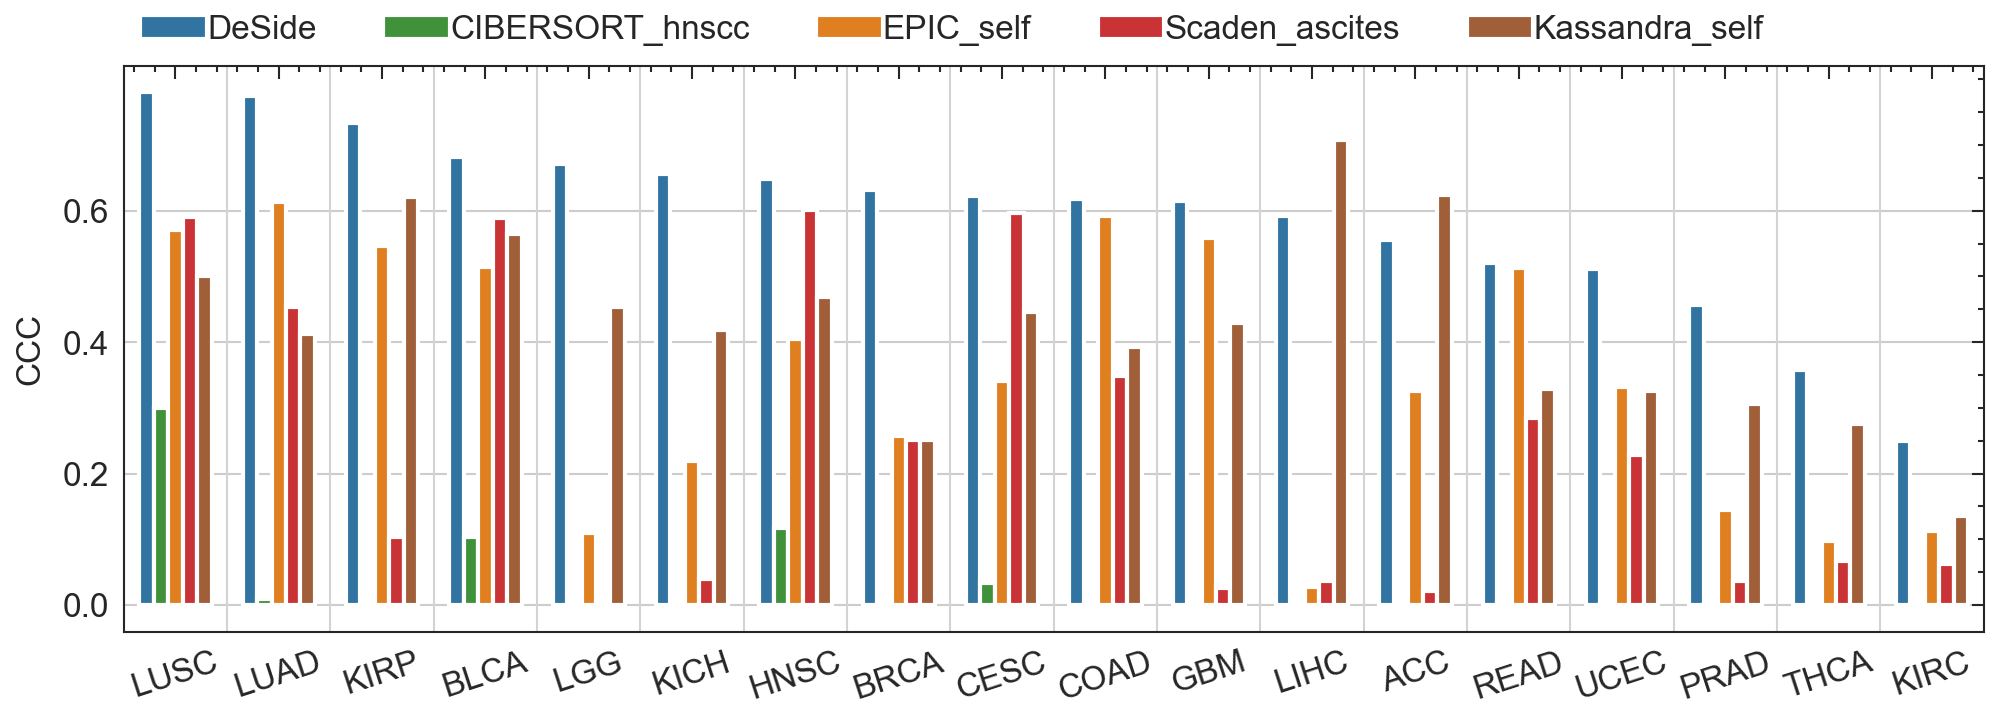

In [24]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(8, 2.5))
width = 0.7
g1 = sns.barplot(data=ccc_values_5_algo, x='cancer_type', y='ccc', hue='algorithm', ax=ax1, width=width, order=cancer_type2ccc_5_algo['cancer_type'].to_list(), palette=color_5)
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(len(cancer_types)):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(18)
# ax.legend(fontsize=6, loc='best')
ax1.set_yticks([0.0, 0.2, 0.4, 0.6])
ax1.set_xlabel('')
ax1.set_ylabel('CCC')

plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_algo.svg'), dpi=300)

#### Bar plot to compare CCC value across 6 different algorithms 
- Predicted cell proportions of cancer cells vs CPE (Fig. S3-S4)

In [25]:
ccc_values

,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548
2,CIBERSORT_hnscc,ACC,-0.160,0.893,-0.002
3,EPIC_self,ACC,0.615,0.188,0.325
4,Scaden_ascites,ACC,0.616,0.575,0.022
...,...,...,...,...,...
139,EPIC_self,UCEC,0.380,0.136,0.332
140,Scaden_ascites,UCEC,0.296,0.152,0.228
141,Kassandra_self,UCEC,0.559,0.203,0.326
142,CIBERSORT_luad,UCEC,0.394,0.241,0.180


In [26]:
algo_all_eight = ['DeSide', 'DeSide_softmax', 'CIBERSORT_hnscc', 'CIBERSORT_luad', 'Scaden_ascites', 'Scaden_simu_bulk', 'EPIC_self', 'Kassandra_self']
ccc_values_all_eight = ccc_values.loc[ccc_values['algorithm'].isin(algo_all_eight), :].copy()
print(ccc_values_all_eight.shape)
ccc_values_all_eight.head(2)

(144, 5)


,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548


In [27]:
color_pair = [sns.color_palette("Paired")[i] for i in [1, 0, 3, 2, 5, 4, 7, 11]]
sns.color_palette(color_pair)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (1.0, 0.4980392156862745, 0.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

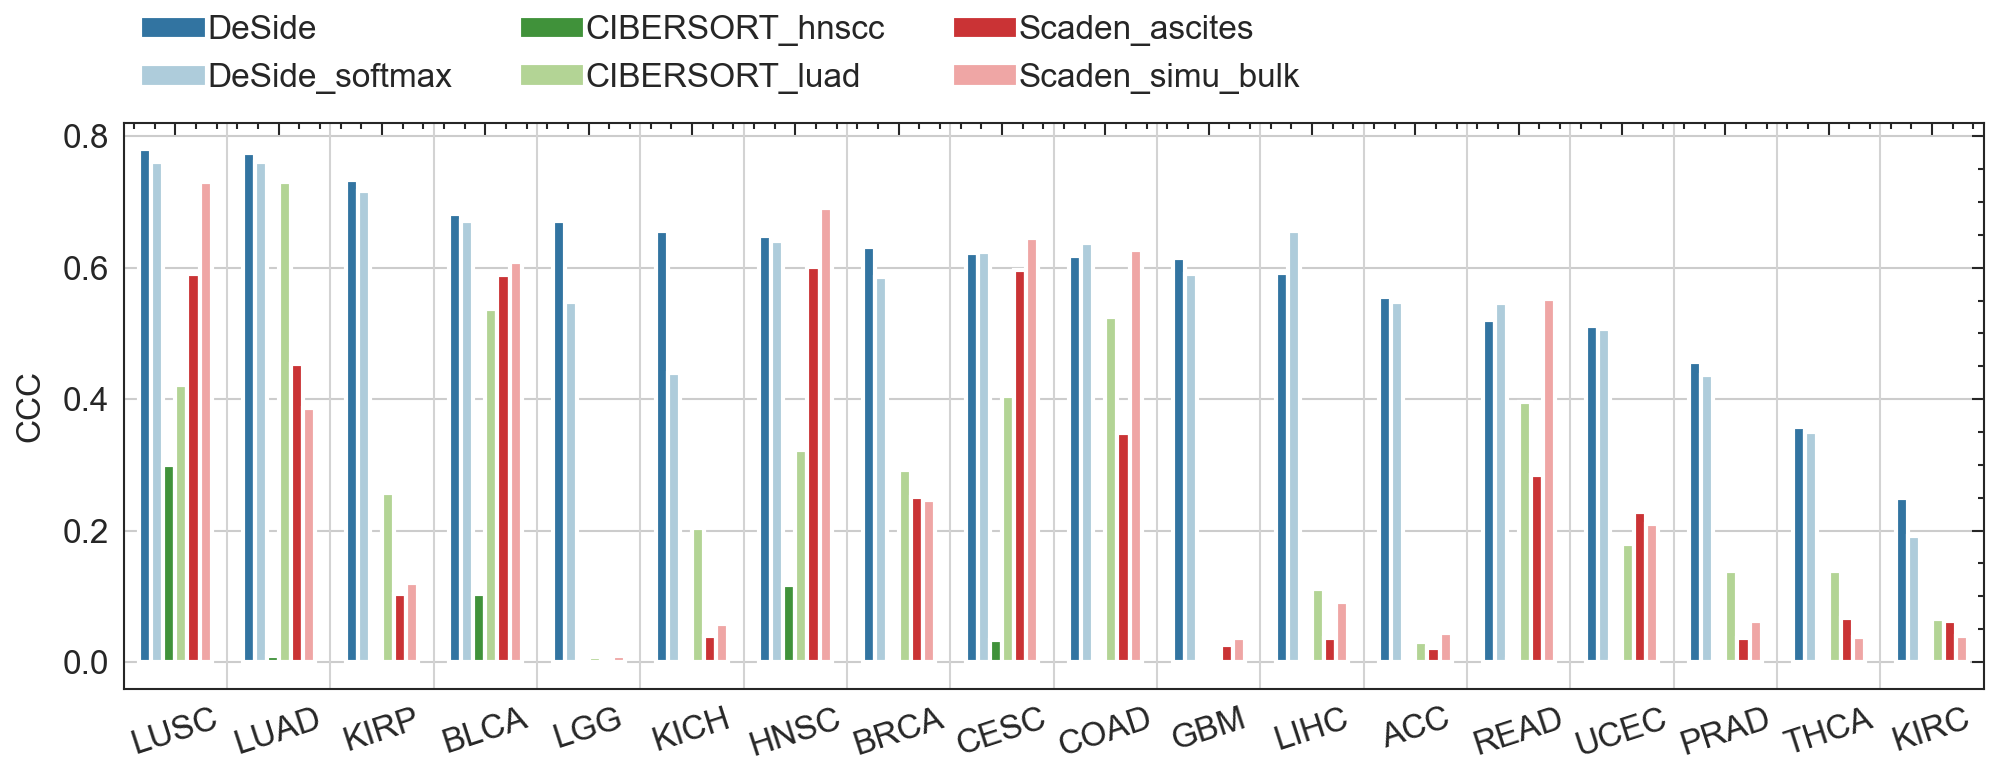

In [28]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(8, 2.5))
width = 0.7
g1 = sns.barplot(data=ccc_values_all_eight.loc[~ccc_values_all_eight['algorithm'].isin(['EPIC_self', 'Kassandra_self'])], x='cancer_type', y='ccc', ax=ax1, 
                 width=width, palette=color_pair[:-2], hue='algorithm', order=cancer_type2ccc_5_algo['cancer_type'].to_list(),
                 hue_order=['DeSide', 'DeSide_softmax', 'CIBERSORT_hnscc', 'CIBERSORT_luad', 'Scaden_ascites', 'Scaden_simu_bulk'])
# g2 = sns.stripplot(data=ccc_values_all_eight, x="algorithm", y="ccc", size=2, color=".3", linewidth=0, order=algo_all_eight)
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.22), ncol=3, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(len(cancer_types)):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(18)
# # ax.legend(fontsize=6, loc='best')
# ax1.set_yticks([0.0, 0.2, 0.4, 0.6])
ax1.set_xlabel('')
ax1.set_ylabel('CCC')

plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_pairwise_barplot.svg'), dpi=300)

#### Calculate P-values (Wilcoxon signed-rank test)

In [29]:
# # # paired t-test
# algo2p_values = {}
# # ccc_values_all_eight_without_nc = ccc_values_all_eight.loc[~ccc_values_all_eight['cancer_type'].isin(['LGG', 'GBM']), :].copy()
# deside_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'DeSide', ['cancer_type', 'ccc']].copy()
# for algo in algo_all_eight[2:]:
#     _ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == algo, ['cancer_type', 'ccc']].copy()
#     assert np.all(deside_ccc['cancer_type'].values == _ccc['cancer_type'].values)
#     _, _p = stats.ttest_rel(deside_ccc['ccc'], _ccc['ccc'])
#     algo2p_values[algo] = _p
# algo2p_values

In [30]:
# Wilcoxon signed-rank test
algo2p_values2 = {}
# ccc_values_all_eight_without_nc = ccc_values_all_eight.loc[~ccc_values_all_eight['cancer_type'].isin(['LGG', 'GBM']), :].copy()
deside_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'DeSide', ['cancer_type', 'ccc']].copy()
for algo in algo_all_eight[2:]:
    _ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == algo, ['cancer_type', 'ccc']].copy()
    assert np.all(deside_ccc['cancer_type'].values == _ccc['cancer_type'].values)
    _, _p = stats.wilcoxon(deside_ccc['ccc'], _ccc['ccc'])
    algo2p_values2[algo] = _p
algo2p_values2

{'CIBERSORT_hnscc': 7.62939453125e-06,
 'CIBERSORT_luad': 7.62939453125e-06,
 'Scaden_ascites': 7.62939453125e-06,
 'Scaden_simu_bulk': 0.00032806396484375,
 'EPIC_self': 7.62939453125e-06,
 'Kassandra_self': 0.0001068115234375}

In [31]:
# CIBERSORT_hnscc vs CIBERSORT_luad
cibersort_hnscc_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'CIBERSORT_hnscc', ['cancer_type', 'ccc']].copy()
cibersort_luad_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'CIBERSORT_luad', ['cancer_type', 'ccc']].copy()
assert np.all(cibersort_hnscc_ccc['cancer_type'].values == cibersort_luad_ccc['cancer_type'].values)
_, _p = stats.wilcoxon(cibersort_hnscc_ccc['ccc'], cibersort_luad_ccc['ccc'])
_p

7.62939453125e-06

In [32]:
# Scaden_ascites vs Scaden_simu_bulk
scaden_as_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'Scaden_ascites', ['cancer_type', 'ccc']].copy()
scaden_si_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'Scaden_simu_bulk', ['cancer_type', 'ccc']].copy()
assert np.all(scaden_as_ccc['cancer_type'].values == scaden_si_ccc['cancer_type'].values)
_, _p = stats.wilcoxon(scaden_as_ccc['ccc'], scaden_si_ccc['ccc'])
_p

0.04827880859375

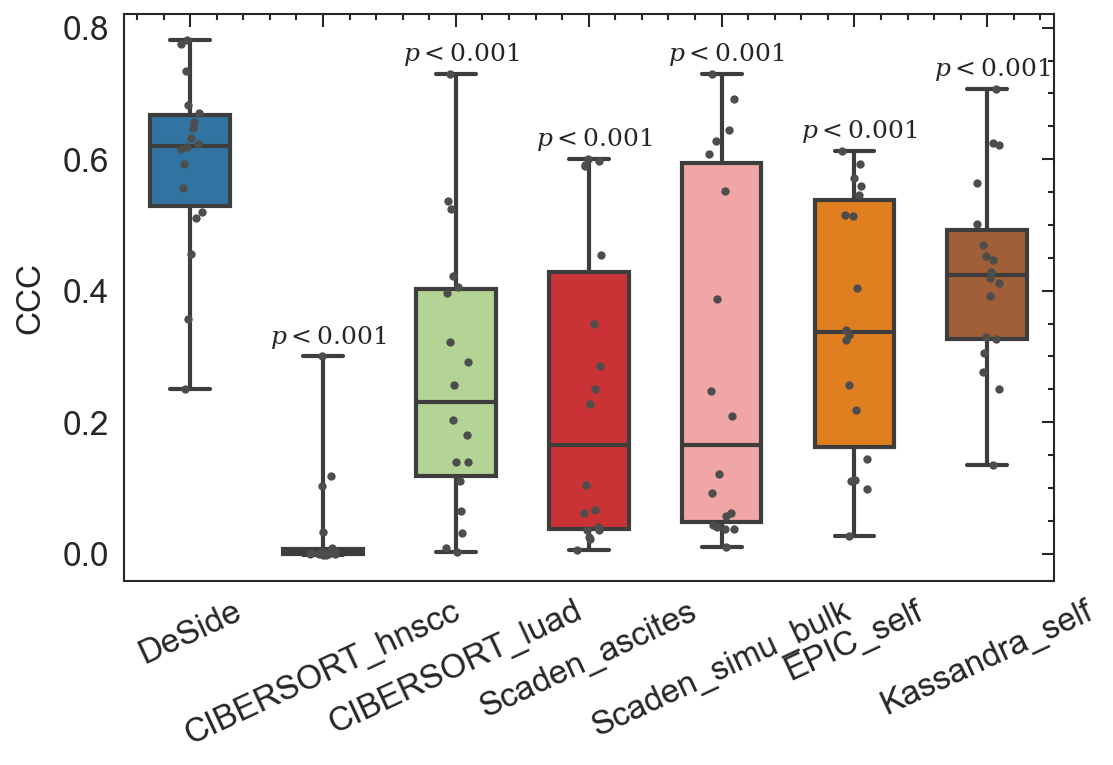

In [33]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(4, 2.5))
width = 0.6
g1 = sns.boxplot(data=ccc_values_all_eight, x='algorithm', y='ccc', ax=ax1, width=width, order=algo_all_eight[0:1] + algo_all_eight[2:], whis=[0, 100], palette=color_pair[0:1] + color_pair[2:])
g2 = sns.stripplot(data=ccc_values_all_eight, x="algorithm", y="ccc", ax=ax1, size=2, color=".3", linewidth=0, order=algo_all_eight[0:1] + algo_all_eight[2:])
for i in range(6):
    _current_algo = algo_all_eight[i+2]
    y_max = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == _current_algo, ['ccc']].max()
    p_value = algo2p_values2[_current_algo]
    if p_value < 0.001:
        plt.text(i+0.6, y_max + 0.02, '$p<0.001$'.format(p_value), fontsize=6)
    else:
        plt.text(i+0.6, y_max + 0.02, '$p={:.3f}$'.format(p_value), fontsize=6)
        
for item in g1.get_xticklabels():
    item.set_rotation(25)
ax1.set_xlabel('')
ax1.set_ylabel('CCC')

plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_algo_pairwise_boxplot.svg'), dpi=300)

In [34]:
ccc_values_all_eight.groupby('algorithm').median()

/var/folders/qj/vrg9kck17g3bhjcg9bf6yk8m0000gp/T/ipykernel_9851/2703772420.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ccc_values_all_eight.groupby('algorithm').median()


,corr,rmse,ccc
algorithm,,,
CIBERSORT_hnscc,0.0525,0.7310,0.0010
CIBERSORT_luad,0.6285,0.2745,0.2305
DeSide,0.7345,0.1120,0.6205
DeSide_softmax,0.7285,0.1165,0.5880
EPIC_self,0.5175,0.1735,0.3365
Kassandra_self,0.7110,0.1940,0.4240
Scaden_ascites,0.5990,0.2790,0.1660
Scaden_simu_bulk,0.6150,0.3240,0.1655


In [35]:
def plot_single_ax(ax, cols:tuple, pred_cell_frac, flow_score, rescaling_score: bool = False, plot_diag=True, 
                   show_xlabel=False, remove_xticks=False, show_ylabel=False, remove_outlier=(), algo='', non_epi_samples=None):
    plt.sca(ax)
    if cols:
        col_name1, col_name2 = cols  # column of predicted cell proportion, column of flow score
        current_flow_score = flow_score.loc[flow_score[col_name2].notna(), [col_name2]]
        
        if non_epi_samples is not None:
            current_flow_score = current_flow_score.loc[~current_flow_score.index.isin(non_epi_samples), :].copy()
        print('The shape of current_flow_score (before)', current_flow_score.shape, cols)
        if col_name2 in remove_outlier:
            current_flow_score = current_flow_score.loc[current_flow_score[col_name2] <= remove_outlier[1], :].copy()
            print('The shape of current_flow_score (after)', current_flow_score.shape)
        current_cell_frac = pred_cell_frac.loc[current_flow_score.index, [col_name1]]
        if rescaling_score:
            # print(current_flow_score.shape)
            current_flow_score = current_flow_score / current_flow_score.max(axis=0)
            current_cell_frac = current_cell_frac / current_cell_frac.max(axis=0)
        
        assert np.all(current_flow_score.index == current_cell_frac.index)
        # print(current_cell_frac, current_flow_score)
        corr, p_value = get_corr(current_cell_frac[col_name1], current_flow_score[col_name2], return_p_value=True)
        rmse = calculate_rmse(y_true=current_flow_score, y_pred=current_cell_frac)
        ccc = get_ccc(current_cell_frac[col_name1].values, current_flow_score[col_name2].values)
        plt.scatter(current_cell_frac, current_flow_score, s=1)
        if rescaling_score:
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
        x_left, x_right = plt.xlim()
        y_bottom, y_top = plt.ylim()
        # plt.ylim([y_bottom, current_flow_score.max() + 1])
        y_bottom, y_top = plt.ylim()
        # print(y_top, current_flow_score.max(), ax.get_ylim())
        if show_ylabel:
            plt.ylabel('{} ({} samples)'.format(col_name2, current_flow_score.shape[0]), fontsize=6)
        if show_xlabel:
            plt.xlabel('{}'.format(algo), fontsize=6)
            # ax.yaxis.set_label_position("right")
            # ax.yaxis.tick_right()
        plt.text(0.02, 0.85, '$CCC={:.3f}$'.format(ccc), fontsize=6, transform=ax.transAxes)
        plt.text(0.02, 0.75, '$r={:.3f}$'.format(corr), fontsize=6, transform=ax.transAxes)
        
        if p_value < 0.001:
            plt.text(0.35, 0.75, '(p<0.001)'.format(p_value), fontsize=6, transform=ax.transAxes)
        else:
            plt.text(0.35, 0.75, '(p={:.3f})'.format(p_value), fontsize=6, transform=ax.transAxes)
        # else:
            # ax.text(0.01, y_top * 0.85, 'corr = {:.2f}'.format(corr[0, 1]), fontsize=6, transform=ax.transAxes)
        if plot_diag:
            _ = max(x_right, y_top)
            ax.plot([0, _], [0, _], linestyle='--', color='tab:gray')
            if rescaling_score:
                ax.text(0.02, 0.65, '$RMSE={:.2f}$'.format(rmse), fontsize=6, transform=ax.transAxes)
            else:
                ax.text(0.01, 0.72, '$RMSE={:.2f}$'.format(rmse), fontsize=6, transform=ax.transAxes)
            _ = max(x_right, y_top)
        if remove_xticks:
            ax.set_xticks([])
    else:
        ax.plot([0, 0.2], [0, 0.2], linestyle='--', color='tab:gray')
    return ax, ccc

---

### 1. Dataset (GSE184398) - flow score (acquired from experiment)
- From Combes et al., 2022, Cell 185, 184–203
- The most common stromal cells include fibroblasts and pericytes. 

In [36]:
pred_cell_prop_dir = os.path.join(result_dir, 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering')
result_dir = os.path.join(pred_cell_prop_dir, 'ind_test_set')
ind_dataset_dir = os.path.join(dataset_dir, 'Independent_Test_Set')
check_dir(result_dir)

In [37]:
flow_score = pd.read_csv('../datasets/Independent_Test_Set/Combes et al., 2022, Cell/flow_score.csv', index_col=0)
print(flow_score.shape)
flow_score.head(2)

(224, 10)


,Tcells,Myeloid,Stroma,CD4,CD8,treg,Classical mono,Macro,cDC1,cDC2
IPICRC058.T1,NaN,NaN,NaN,NaN,NaN,NaN,6.22,13.3,3.8,2.52
IPICRC060.T1,8.43,0.5,0.1,56.6,13.4,0.2,NaN,NaN,NaN,NaN


#### 1.1 Predicted cell fractions by DeSide

In [38]:
pred_cell_prop_dir

'../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering'

In [39]:
deside_parameters = {'architecture': ([200, 2000, 2000, 2000, 50],
                                      [0, 0, 0, 0.2, 0]),
                     'architecture_for_pathway_network': ([50, 500, 500, 500, 50],
                                                          [0, 0, 0, 0, 0]),
                     'loss_function_alpha': 0.5,  # alpha*mae + (1-alpha)*rmse, mae means mean absolute error
                     'normalization': 'layer_normalization',  # batch_normalization / layer_normalization / None
                     # 1 means to add a normalization layer, input | the first hidden layer | ... | output
                     'normalization_layer': [0, 0, 1, 1, 1, 0],  # 1 more parameter than the number of hidden layers
                     'pathway_network': True,  # using an independent pathway network
                     'last_layer_activation': 'sigmoid',  # sigmoid / softmax
                     'learning_rate': 1e-4,
                     'batch_size': 128}

# read two gene sets as pathway mask
gene_set_file_path1 = os.path.join(dataset_dir, 'gene_set', 'c2.cp.kegg.v2023.1.Hs.symbols.gmt')
gene_set_file_path2 = os.path.join(dataset_dir, 'gene_set', 'c2.cp.reactome.v2023.1.Hs.symbols.gmt')
all_pathway_files = [gene_set_file_path1, gene_set_file_path2]
pathway_mask = read_gene_set(all_pathway_files)  # genes by pathways

In [40]:
bulk_tpm_file_path_ds1 = os.path.join(ind_dataset_dir, 'Combes et al., 2022, Cell', 'GSE184398_pancan_all_pc_genes_Live_TPM_Aug_3_20.tsv')
model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')
result_dir = os.path.join(pred_cell_prop_dir, 'ITS_Combes_Cell_2022')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result.csv')
deside_model = DeSide(model_dir=model_dir)
deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                     output_file_path=y_pred_file_path,
                     exp_type='TPM', transpose=True, scaling_by_sample=False,
                     scaling_by_constant=True, 
                     # new parameters
                     hyper_params=deside_parameters, pathway_mask=pathway_mask)

   Start to predict cell fractions by pre-trained model...
   8499 common genes will be used, 49489 genes will be removed.
   529 genes are not in current dataset, 0 will be filled
   9032 genes will be used to construct the pathway profiles.
common genes between training set and pathway mask: 5462
genes only in training set: 3566
   9028 common genes will be used, 0 genes will be removed.
x shape: (260, 10872)
   10868 common genes will be used, 0 genes will be removed.
   > 10868 genes included in pre-trained model and will be used for prediction.
   The shape of X is: (260, 10868), (n_sample, n_gene)
   Pre-trained model loaded from ../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/DeSide_model/model_DeSide.h5.
9/9 [==============================] - 0s 10ms/step
   Model prediction done.


In [41]:
pred_cell_frac_deside = pd.read_csv(y_pred_file_path, index_col=0)
pred_cell_frac_deside.head(2)

,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,DC,Endothelial Cells,CAFs,Myofibroblasts,Macrophages,Mast Cells,NK,Neutrophils,Monocytes,1-others,Cancer Cells
IPIGYN015.T1,0.0,0.018,0.003,0.000,0.0,0.0,0.010,0.0,0.0,0.002,0.0,0.008,0.0,0.079,0.0,0.880,0.880
IPIGYN019.T1,0.0,0.004,0.000,0.001,0.0,0.0,0.001,0.0,0.0,0.001,0.0,0.000,0.0,0.000,0.0,0.992,0.992


In [42]:
pred_cell_frac_deside.shape

(260, 17)

In [43]:
pred_cell_frac_deside = pred_cell_frac_deside.loc[flow_score.index, :].copy()
np.all(pred_cell_frac_deside.index == flow_score.index)

True

In [44]:
t_cells = ['CD4 T', 'CD8 T effector', 'CD8 T (GZMK high)']
pred_cell_frac_deside['Tcell'] = pred_cell_frac_deside[t_cells].sum(axis=1)
# pred_cell_frac_deside['Myeloid'] = pred_cell_frac_deside[['DC', 'Macrophages', 'Monocytes', 'Neutrophils']].sum(axis=1)
pred_cell_frac_deside['Myeloid'] = pred_cell_frac_deside[['DC', 'Macrophages', 'Monocytes']].sum(axis=1)
pred_cell_frac_deside['Stroma'] = pred_cell_frac_deside[['CAFs', 'Myofibroblasts', 'Endothelial Cells']].sum(axis=1)
pred_cell_frac_deside['Fib'] = pred_cell_frac_deside[['CAFs', 'Myofibroblasts']].sum(axis=1)
pred_cell_frac_deside.head(2)

,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,DC,Endothelial Cells,CAFs,Myofibroblasts,...,Mast Cells,NK,Neutrophils,Monocytes,1-others,Cancer Cells,Tcell,Myeloid,Stroma,Fib
IPICRC058.T1,0.001,0.010,0.111,0.240,0.025,0.000,0.052,0.001,0.0,0.0,...,0.002,0.021,0.408,0.012,0.107,0.107,0.376,0.076,0.001,0.0
IPICRC060.T1,0.012,0.013,0.022,0.007,0.000,0.061,0.019,0.000,0.0,0.0,...,0.008,0.000,0.018,0.000,0.837,0.837,0.029,0.021,0.000,0.0


#### 1.2 Predicted cell fractions by CIBERSORTx (HNSC)

In [45]:
# pred_cell_frac_file_path = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/CIBERSORTx_Job34_Results_Mix_GSE184398.csv'
pred_cell_frac_file_path_cibersortx = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/CIBERSORTx_Job73_Results_default_HNSCC_sig_matrix.csv'

In [46]:
pred_cell_frac_cibx = pd.read_csv(pred_cell_frac_file_path_cibersortx, index_col=0)
pred_cell_frac_cibx.head(2)

,T cells CD8,T cells CD4,Fibroblast,Macrophage,B cell,Malignant,Mast,Dendritic,Myocyte,Endothelial,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,,,
IPIGYN015.T1,0.152408,0.324515,0.105467,0.273076,0.000164,0.007623,0.000165,0.131948,0.000845,0.003788,0,0.195575,0.988225
IPIGYN019.T1,0.244288,0.089860,0.161068,0.171631,0.001666,0.004836,0.000750,0.028979,0.000000,0.296922,0,0.018639,1.031273


In [47]:
pred_cell_frac_cibx.shape

(260, 13)

In [48]:
pred_cell_frac_cibx = pred_cell_frac_cibx.loc[flow_score.index, :].copy()
print(pred_cell_frac_cibx.shape)
np.all(pred_cell_frac_cibx.index == flow_score.index)

(224, 13)


True

In [49]:
pred_cell_frac_cibx['Tcell'] = pred_cell_frac_cibx[['T cells CD8', 'T cells CD4']].sum(axis=1)
pred_cell_frac_cibx['Myeloid'] = pred_cell_frac_cibx[['Dendritic', 'Macrophage']].sum(axis=1)
pred_cell_frac_cibx['Stroma'] = pred_cell_frac_cibx[['Fibroblast', 'Endothelial']].sum(axis=1)
pred_cell_frac_cibx.head(2)

,T cells CD8,T cells CD4,Fibroblast,Macrophage,B cell,Malignant,Mast,Dendritic,Myocyte,Endothelial,P-value,Correlation,RMSE,Tcell,Myeloid,Stroma
IPICRC058.T1,0.468362,0.209532,0.0,0.264863,0.000000,0.000000,0.000142,0.057101,0.0,0.0,0,0.344078,0.939322,0.677894,0.321964,0.0
IPICRC060.T1,0.000000,0.712861,0.0,0.170566,0.006729,0.029358,0.001897,0.078589,0.0,0.0,0,0.174165,0.993477,0.712861,0.249154,0.0


#### 1.3 Predicted cell fraction by Scaden (Ascites)

In [50]:
pred_cell_frac_file_path_scaden = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/scaden_ascites_pred_cell_frac_GSE184398.txt'

In [51]:
pred_cell_frac_scaden = pd.read_csv(pred_cell_frac_file_path_scaden, index_col=0, sep='\t')
pred_cell_frac_scaden.head(2)

,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast
IPIGYN015.T1,0.052628,0.160707,0.502286,0.047025,0.037447,0.134950,0.064958
IPIGYN019.T1,0.039677,0.033410,0.590617,0.037487,0.057873,0.139424,0.101511


In [52]:
pred_cell_frac_scaden.shape

(260, 7)

In [53]:
pred_cell_frac_scaden = pred_cell_frac_scaden.loc[flow_score.index, :].copy()
print(pred_cell_frac_scaden.shape)
np.all(pred_cell_frac_scaden.index == flow_score.index)

(224, 7)


True

In [54]:
pred_cell_frac_scaden['Tcell'] = pred_cell_frac_scaden[['CD4Tcells', 'CD8Tcells']].sum(axis=1)
pred_cell_frac_scaden['Myeloid'] = pred_cell_frac_scaden[['Monocytes', 'DC']].sum(axis=1)
pred_cell_frac_scaden.head(2)

,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast,Tcell,Myeloid
IPICRC058.T1,0.115267,0.410683,0.117485,0.094439,0.032733,0.210140,0.019254,0.325407,0.443416
IPICRC060.T1,0.034475,0.101666,0.464386,0.054981,0.036921,0.269388,0.038182,0.303863,0.138587


#### 1.4 Predicted cell fraction by Kassandra

In [55]:
pred_cell_frac_file_path_k_dir = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/Kassandra'
pred_cell_frac_ka_list = []
for i in range(3):
    _file_path = os.path.join(pred_cell_frac_file_path_k_dir, f'predictions_{i}.tsv')
    _current_cf = pd.read_csv(_file_path, sep='\t', index_col=0).T
    pred_cell_frac_ka_list.append(_current_cf)
pred_cell_frac_ka = pd.concat(pred_cell_frac_ka_list) / 100
print(pred_cell_frac_ka.shape)
pred_cell_frac_ka.head(2)

(260, 22)


,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,...,NK_cells,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs,Monocytic_cells,Stromal_cells
IPIGYN015.T1,0.0193,0.1956,0.0525,0.0332,0.0193,0.0000,0.0027,0.2758,0.0089,0.0048,...,0.0085,0.2689,0.0189,0.4317,0.0004,0.2481,0.0510,0.1445,0.0209,0.0027
IPIGYN019.T1,0.0083,0.0054,0.0316,0.0155,0.0161,0.0009,0.0054,0.0508,0.0007,0.0000,...,0.0054,0.0008,0.0072,0.9359,0.0011,0.0370,0.0001,0.0050,0.0061,0.0063


In [56]:
pred_cell_frac_ka.to_csv(os.path.join(pred_cell_frac_file_path_k_dir, 'GSE184398_pancan_predicted_by_Kassandra.csv'))

In [57]:
# pred_cell_frac_ka['Myeloid'] = pred_cell_frac_ka[['Macrophages', 'Monocytes', 'Neutrophils']].sum(axis=1)
pred_cell_frac_ka['Myeloid'] = pred_cell_frac_ka[['Macrophages', 'Monocytes']].sum(axis=1)

pred_cell_frac_ka.head(2)

,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,...,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs,Monocytic_cells,Stromal_cells,Myeloid
IPIGYN015.T1,0.0193,0.1956,0.0525,0.0332,0.0193,0.0000,0.0027,0.2758,0.0089,0.0048,...,0.2689,0.0189,0.4317,0.0004,0.2481,0.0510,0.1445,0.0209,0.0027,0.0209
IPIGYN019.T1,0.0083,0.0054,0.0316,0.0155,0.0161,0.0009,0.0054,0.0508,0.0007,0.0000,...,0.0008,0.0072,0.9359,0.0011,0.0370,0.0001,0.0050,0.0061,0.0063,0.0061


In [58]:
dataset_info = pd.read_csv(os.path.join(ind_dataset_dir, 'Combes et al., 2022, Cell',  '1-s2.0-S0092867421014264-mmc1.csv'), 
                           index_col=0, encoding='latin-1')
dataset_info.head(2)

,indication,Gender,Race,Ethnicity,BMI,Age,Pathologic T Stage,Pathologic N Stage,Pathologic M Stage,Grade,Histology,Tumor type,Extraction Site
Sample,,,,,,,,,,,,,
IPIBLAD005.T1,BLAD,Male,White,Non Hispanic or Latino,21.0,77.0,3b,NaN,0,G3: Poorly differentiated (high grade),"Carcinoma, NOS",Primary,Bladder
IPIBLAD006.T1,BLAD,Male,Asian,Non Hispanic or Latino,23.0,65.0,4a,2,NaN,G3: Poorly differentiated (high grade),Not Available,Primary,Bladder


In [59]:
non_epithetial_tumors = ['MEL', 'SRC']  # ['MEL', 'PNET', 'BGM', 'SRC']
non_epi_samples = dataset_info.loc[dataset_info['indication'].isin(non_epithetial_tumors), :].copy()
print(non_epi_samples.shape)
non_epi_samples.head(2)

(41, 13)


,indication,Gender,Race,Ethnicity,BMI,Age,Pathologic T Stage,Pathologic N Stage,Pathologic M Stage,Grade,Histology,Tumor type,Extraction Site
Sample,,,,,,,,,,,,,
IPIMEL056.T1,MEL,Male,White,Non Hispanic or Latino,28.0,41.0,4b,3,1,Not Available,Nevi & Melanomas,Metastasis,left axillary sentinel lymph node
IPIMEL069.T1,MEL,Male,White,Non Hispanic or Latino,20.0,48.0,1,3,0,Not Available,Nevi & Melanomas,Metastasis,left groin


The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('T_cells', 'Tcells')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (72, 1) ('Stroma', 'Stroma')
The shape of current_flow_score (after) (70, 1)
The shape of current_flow_score (before) (72, 1) ('Stroma', 'Stroma')
The shape of current_flow_score (after) (70, 1)
The shape of current_flow_score (before) (72, 1) ('Fibroblast', 'Stroma')
The shape of current_flow_score (after) (70, 1)
The shape of current_flow_score (before) (72, 1) ('Stromal_cells', 'Stroma')

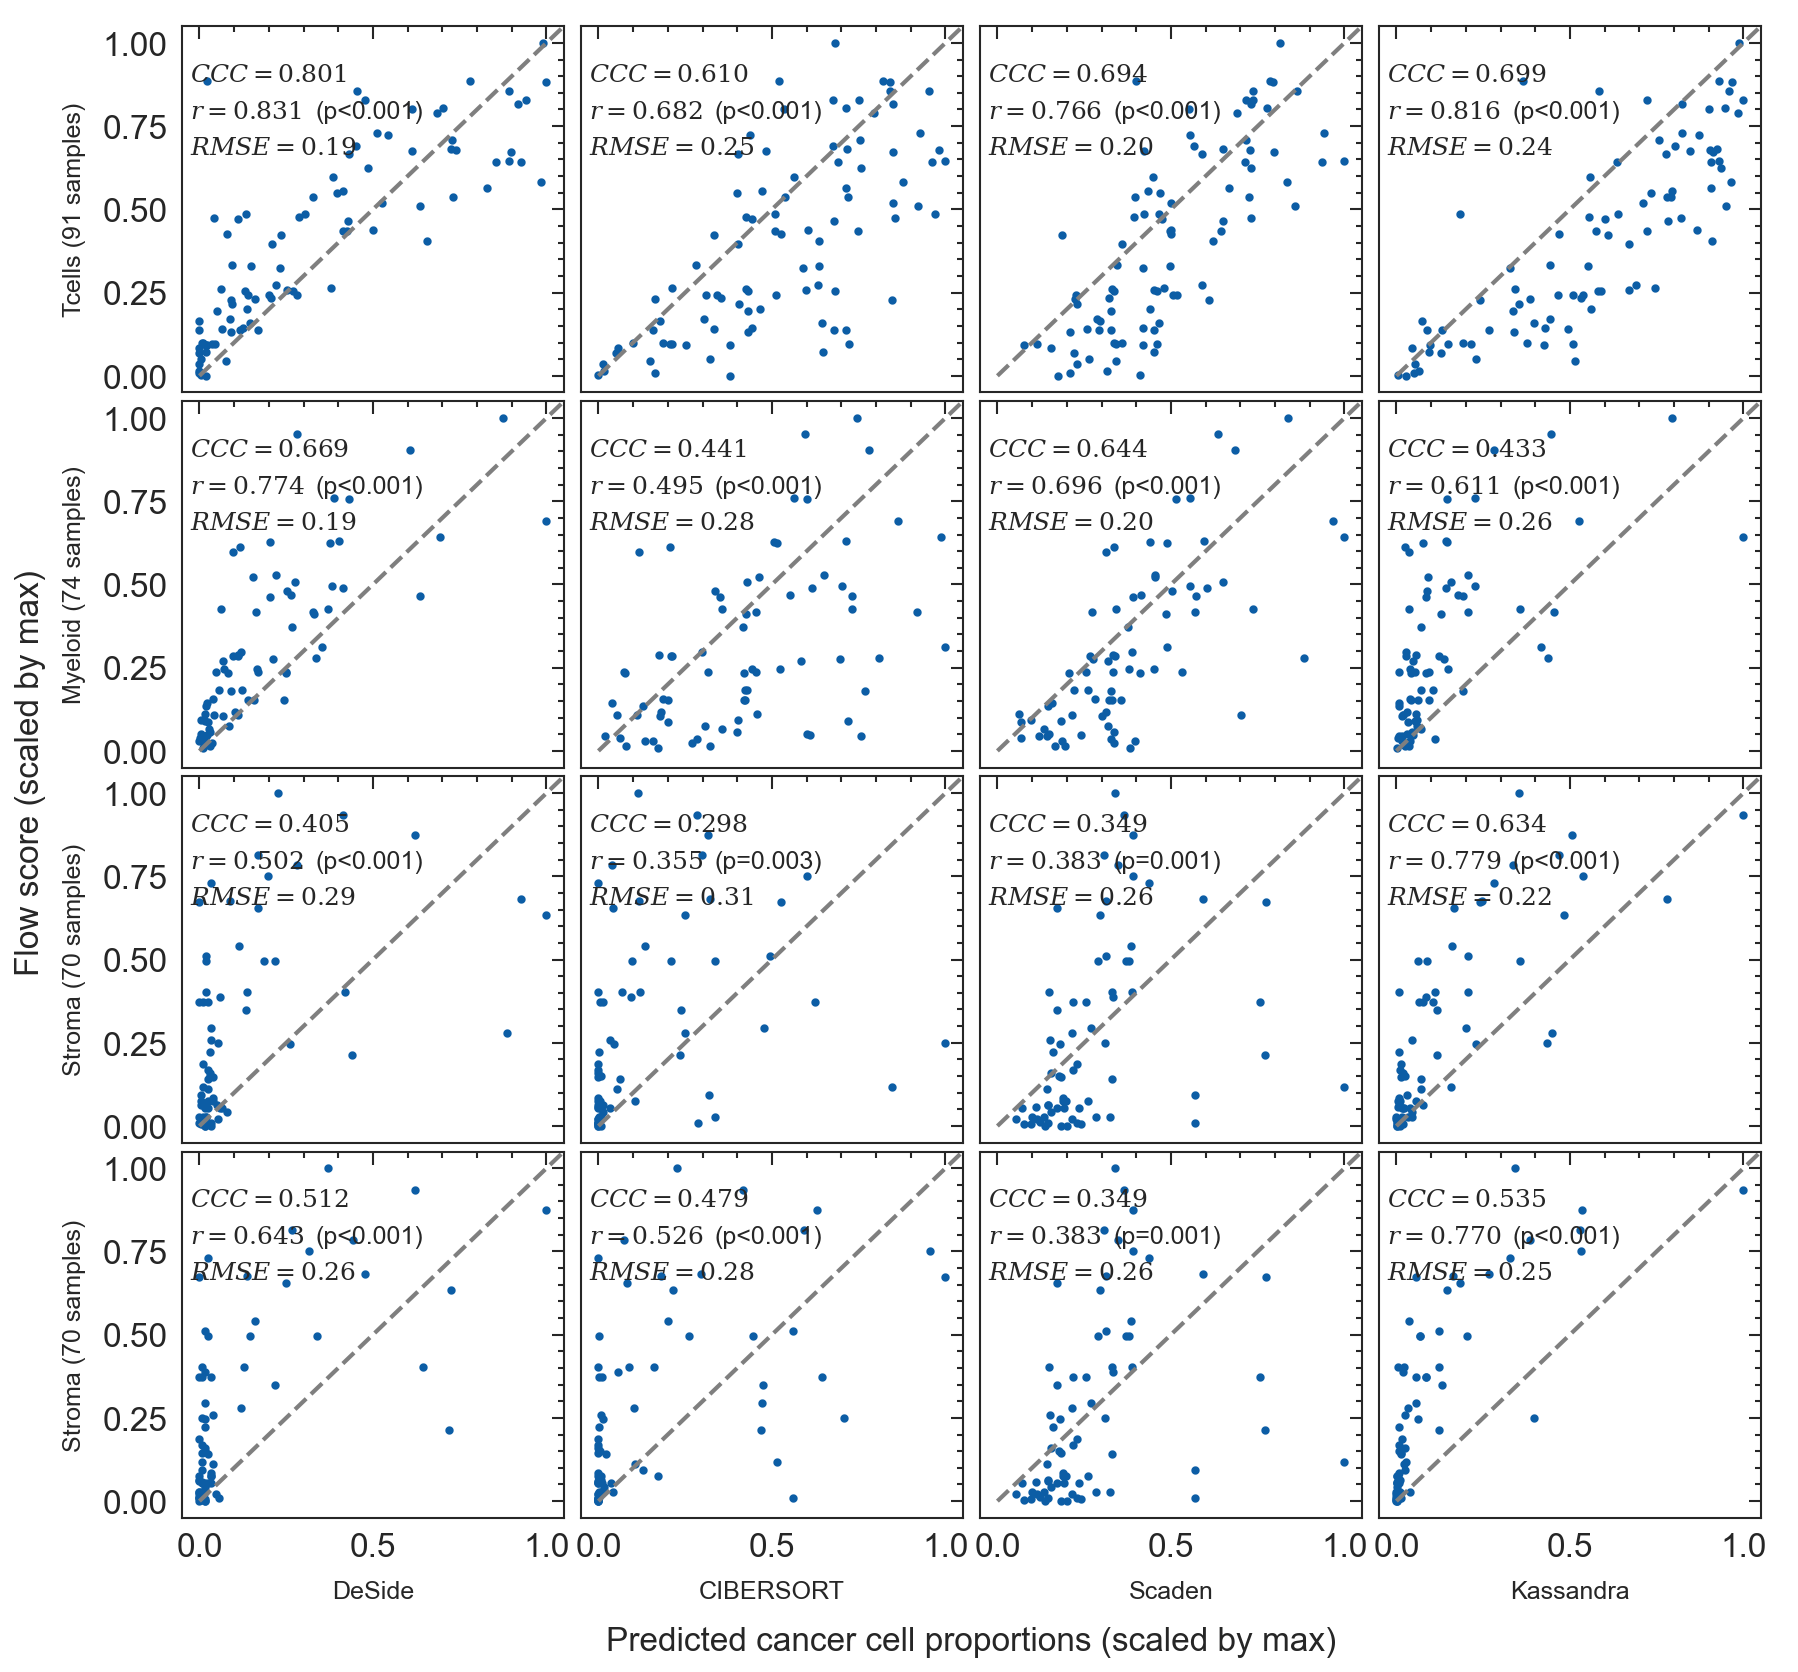

In [60]:
algos = ['DeSide', 'CIBERSORT', 'Scaden', 'Kassandra']
predicted_results = {'DeSide': pred_cell_frac_deside, 'CIBERSORT': pred_cell_frac_cibx, 'Scaden': pred_cell_frac_scaden, 'Kassandra': pred_cell_frac_ka}
rescaling_score = True
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6.5, 6))
ccc_values2 = {}
for i in range(4):
    for j in range(4):
        show_ylabel = False
        if j == 0:
            show_ylabel = True
        current_algo = algos[j]
        current_result = predicted_results[current_algo]
        i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Stroma', 'Stroma'), 3: ('Fib', 'Stroma')}
        # i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fib', 'Stroma')}
        if current_algo == 'Scaden':
            i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma'), 3: ('Fibroblast', 'Stroma')}
            # i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma')}
        elif current_algo == 'Kassandra':
            i2cols = {0: ('T_cells', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Stromal_cells', 'Stroma'), 3: ('Fibroblasts', 'Stroma')}
            # i2cols = {0: ('T_cells', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblasts', 'Stroma')}
        elif current_algo == 'CIBERSORT':
            i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Stroma', 'Stroma'), 3: ('Fibroblast', 'Stroma')}
            # i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma')}

        if i <= 2:
            ax, ccc = plot_single_ax(ax=axes[i, j], cols=i2cols[i], pred_cell_frac=current_result, flow_score=flow_score, plot_diag=True, remove_outlier=('Stroma', 50),
                           algo=current_algo, show_ylabel=show_ylabel, non_epi_samples=non_epi_samples.index.to_list(), rescaling_score=rescaling_score)
        else:
            ax, ccc = plot_single_ax(ax=axes[i, j], cols=i2cols[i], pred_cell_frac=current_result, flow_score=flow_score, plot_diag=True, remove_outlier=('Stroma', 50), 
                           show_ylabel=show_ylabel, algo=current_algo, show_xlabel=True, non_epi_samples=non_epi_samples.index.to_list(), rescaling_score=rescaling_score)
        ccc_values2[(current_algo, i2cols[i][1], i2cols[i][0])] = ccc

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Predicted cancer cell proportions (scaled by max)', labelpad=15)
if rescaling_score:
    plt.ylabel("Flow score (scaled by max)", labelpad=18)
else:
    plt.ylabel("Flow score (scaled by max)", labelpad=18)

plt.tight_layout(h_pad=0.1, w_pad=0.02)
plt.savefig(os.path.join(fig_dir, 'r-sec5-1_table2_scatter.svg'), dpi=300)

In [61]:
ccc_values_gse = pd.DataFrame.from_dict(ccc_values2, orient='index', columns=['CCC'])
ccc_values_gse = ccc_values_gse.reset_index()
ccc_values_gse.loc[15] = [('Scaden', 'Stroma', 'Stroma')] + ccc_values_gse.loc[10].to_list()[1:]
ccc_values_gse['algo'] = ccc_values_gse['index'].map(lambda x: x[0])
ccc_values_gse['cell_type'] = ccc_values_gse['index'].map(lambda x: 'Fibroblast' if 'Fib' in x[2] else x[1])
ccc_values_gse

,index,CCC,algo,cell_type
0,"(DeSide, Tcells, Tcell)",0.801427,DeSide,Tcells
1,"(CIBERSORT, Tcells, Tcell)",0.610238,CIBERSORT,Tcells
2,"(Scaden, Tcells, Tcell)",0.693588,Scaden,Tcells
3,"(Kassandra, Tcells, T_cells)",0.698877,Kassandra,Tcells
4,"(DeSide, Myeloid, Myeloid)",0.668777,DeSide,Myeloid
5,"(CIBERSORT, Myeloid, Myeloid)",0.441471,CIBERSORT,Myeloid
6,"(Scaden, Myeloid, Myeloid)",0.643775,Scaden,Myeloid
7,"(Kassandra, Myeloid, Myeloid)",0.432696,Kassandra,Myeloid
8,"(DeSide, Stroma, Stroma)",0.405444,DeSide,Stroma
9,"(CIBERSORT, Stroma, Stroma)",0.298025,CIBERSORT,Stroma


In [62]:
ccc_values_gse.loc[10].to_list()[1:]

[0.34939446277014036, 'Scaden', 'Fibroblast']

In [63]:
color = [sns.color_palette("Paired")[i] for i in [1, 3, 5, 11]]
sns.color_palette(color)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

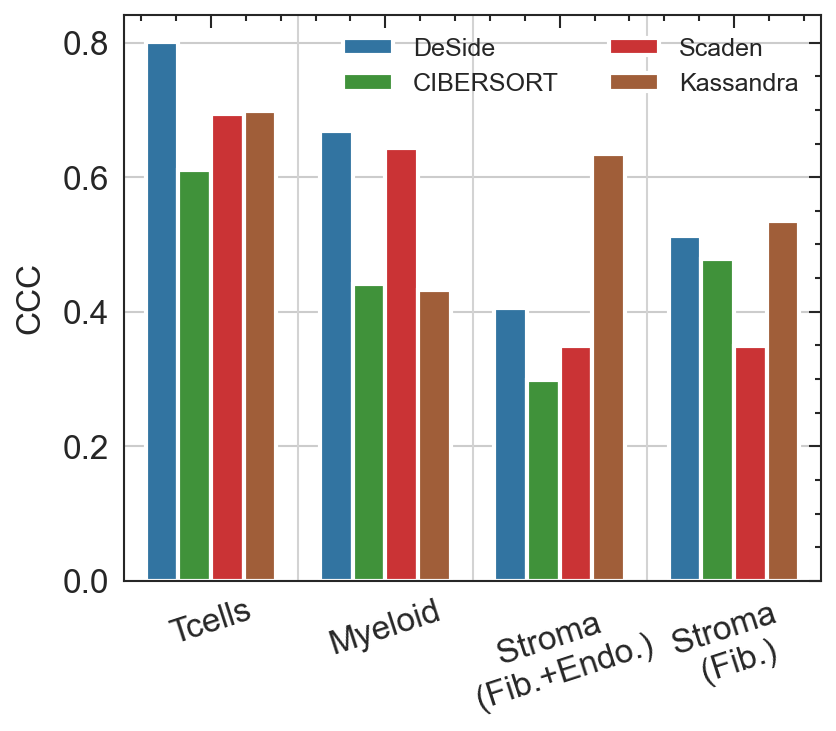

In [65]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(3, 2.5))
width = 0.75
g1 = sns.barplot(data=ccc_values_gse, x='cell_type', y='CCC', hue='algo', ax=ax1, width=width, 
                 order=['Tcells', 'Myeloid', 'Stroma', 'Fibroblast'], hue_order=['DeSide', 'CIBERSORT', 'Scaden', 'Kassandra'], palette=color)
# g1.legend([],[], frameon=False)

# sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(4):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(18)
ax1.legend(fontsize=6, loc='best', ncol=2)
# ax1.set_yticks([0.0, 0.2, 0.4, 0.6])
ax1.set_xticks(range(4), ['Tcells', 'Myeloid', 'Stroma \n(Fib.+Endo.)', 'Stroma \n(Fib.)'])
ax1.set_xlabel('')
ax1.set_ylabel('CCC')

plt.savefig(os.path.join(fig_dir, 'r-sec5-1_table2_bar.svg'), dpi=300)